# Linear Least Squares

## 03.01 Linear Least Squares

#### Problem: Measurements Have Error
* Measurement errors are inevitable
* Variability can be smoothed out by averaging over more data
* Resulting system is **overdetermined**
  * More equations (rows) than unknowns (columns)

#### Solution: Use Least Squares
* Project higher dimensional data into lower dimensional space
* Suppresses noise and irrelevant detail
* Better written as $Ax \approxeq b$
  * Emphasis that $x$ is not exact solution
* Solution minimizes squared 2-norm of residual
  * $\min_x ||r||_2^2 = \min_x || b - Ax ||_2^2$


What does *linear* mean?
* If $f(t, x)$ is the function represented by $Ax = b$, then coefficients of $A$ are some power of $t$.
$$
f(t, x) = x_1 + x_2 t + x_3 t^2 + ... + x_n t^{n-1}
$$
* Non-linear counterexample.
$$
f(t, x) = x_1 + x_2 e^{t} + x_3 e^{t^2} + ... + x_n e^{t^{n-1}}
$$


Given $m$ data points $(t_i, y_i)$ find n-vector $x$ of parameters that gives best fit to model function $f(t, x)$.

In [1]:
import numpy as np

# Input data $(t_i, y_i)$.
m = 5
t = np.linspace(-1., 1., m)
y = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)

# Solve Ax = y for x.
A = np.column_stack((np.ones(m), t, t*t))
x, r, _, _ = np.linalg.lstsq(A, y, rcond=None)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
np.testing.assert_almost_equal(sq2norm, r)

Plot the observations against the fit.

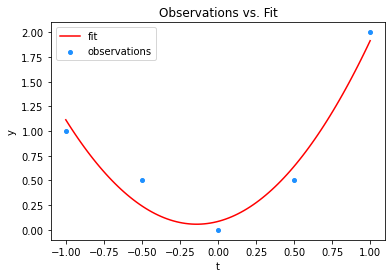

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

# Fit the model to a dense 1D-grid of points from [-1, 1].
fitn = m*20
fitx = np.linspace(-1, 1, fitn)
fitA = np.column_stack((np.ones(fitn), fitx, fitx*fitx))
fity = np.matmul(fitA, x)

# Plot the fitted model against observations.
plt.scatter(t, y, s=16, c='dodgerblue', label='observations')
plt.plot(fitx, fity, c='red', label='fit')
plt.title('Observations vs. Fit')
plt.ylabel('y')
plt.xlabel('t')
plt.legend(loc=0)  # Upper left corner.
plt.show()

## 03.02 Existence, Uniqueness, and Conditioning

* Linear least squares problem $Ax \approxeq b$ **always** has solution.
* Solution unique IFF columns are linearly independent aka $\text{rank}(A) = n$ where $A$ is $m \times n$.

#### Derivation
* To minimize the squared 2-norm of residual we need to find the derivative and set to 0.
$$
\begin{aligned}
||r||_2^2 &= r^T r \\
&= (b - Ax)^T (b - Ax) \\
&= b^T b - 2 x^T A^T b + x^T A^T A x \\
\end{aligned}
$$

* The gradient of $||r||_2^2$ set equal to 0 is aka **normal equations**.
$$
\begin{aligned}
\nabla(||r||_2^2) &= 0 \\
2 A^T A x - 2 A^T b &= 0 \\
A^T A x &= A^T b 
\end{aligned}
$$

* Since $A^TA$ is square, we can use the techniques for solving systems of linear equations to solve linear least squares problems.

#### Orthogonality
* $v_1$ and $v_2$ are othogonal when $v_1^T v_2 = 0$.
* Value of $y = Ax$ closest to solution $b$ occurs when residual $r = b - Ax$ is orthogonal to $\text{span}(A)$.
  * Project higher dimensional data $b$ ($m \times 1$) into lower dimensional space $\text{span}(A)$ (space spanned by columns $n$).
* Angle between $y = Ax$ and $b$ computed as:
  * $\text{cos}(\theta) = \frac{||y||_2}{||b||_2}$


#### Orthogonal Projectors
* $P$ is an orthgonal projector when:
  * $P^2 = P$ aka idempotent
  * $P^T = P$ aka symmetric
* We can decompose any vector $v$ into 2 components:
  * Component in $\text{span}(P)$
  * Component in $\text{span}(P)^{\perp}$ aka orthogonal to $P$
* For least squares $P$ is an orthogonal projector onto $\text{span}(A)$.
  * $P = A (A^T A)^{-1} A^T$

#### Pseudoinverse
* If $A$ is $m \times n$ and $\text{rank}(A) = n$, then pseudoinverse is defined as the inverse of the product of the matrix and its' transpose.
  * $A^{+} = (A^T A)^{-1} A^T$
* Condition number of $A$ defined using pseudoinverse:
  * $\text{cond}(A) = ||A||_2 \cdot ||A^{+}||_2$
* The angle between $y = Ax$ and $b$ also bounds the relative error:
  * $\frac{||\Delta{x}||}{||x||} \leq \text{cond}(A) \frac{1}{\text{cos}(\theta)} \frac{||\Delta{b}||}{||b||}$
  * When the angle $\theta$ is small, then $\theta \approxeq 0$ and value of $\text{cos}(\theta) \approxeq 1$.  As a result, relative error will be small.
  * When the angle $\theta$ is big, then relative error will be large.

## 03.03 Solving Linear Least Squares Problems

#### Normal Equations Method
* If $A$ has rank $n$ then symmetric matrix $A^TA$ is positive definite.
* Use cholesky factorization solve $Ax = b$ for $x$.
  1. Premultiply both sides by $A^T$ to obtain $A^T A x = A^T b$.
  2. Factorize $A^T A$ into $L L^T$ to obtain $L L^T x = A^T b$.
  3. Solve $L z = A^Tb$ for $z$ using forward substitution.
  4. Solve $L^T x = z$ for $x$ using back substitution.
* This technique has problems in finite precision arithmetic.
  * Computing $A^TA$ introduces roundoff.
  * Sensitivity of solution is worsened.
    * $\text{cond}(A^T A) = [\text{cond}(A)]^2$
  * Normal equations method is **unstable** due to these introduced computational errors.

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using cholesky factorization.

In [3]:
import math
import numpy as np
import scipy.linalg as la

# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))

# Premultiply the left and right hand side by A^T.
ATA = np.matmul(A.T, A)
ATb = np.matmul(A.T, b)

# Factorize A^T A into L L^T.
LLT = np.linalg.cholesky(ATA)

# Solve Lz = A^Tb for z using forward substitution.
z = la.solve_triangular(LLT, ATb, lower=True, unit_diagonal=False)

# Solve L^Tx = z for x using back substitution.
x = la.solve_triangular(LLT.T, z, lower=False, unit_diagonal=False)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.04 Orthogonalization Methods

* Matrix $Q$ is orthogonal if $Q^T Q = I$.
* Columns of orthogonal matrix are orthonormal eg orthogonal unit vectors.
* Multiplying vector by orthogonal matrix does not change its' 2-norm.
  * $||Qv||_2^2 = ||v||_2^2$
* Use orthogonalization method to solve $Ax = b$ for $x$.
  * More computationally expensive than elimination.
  * More numerically stable than normal equations method.
  
#### QR Factorization
Given $m \times n$ matrix $A$ find an $m \times m$ matrix $Q$.
$$
A = Q
\begin{bmatrix}
R \\
0
\end{bmatrix}
$$
where
  * Q is an $m \times m$ orthogonal matrix
  * R is an $n \times n$ upper triangular matrix
  * 0 is an $(m-n) \times n$ zero matrix

To compute QR factorization of $A$ use one of orthogonal transformations below.
  * Householder transformations
  * Givens rotations
  * Gram-Schmidt orthogonalization

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using QR factorization via scipy.

In [4]:
import numpy as np
import scipy.linalg as la

# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into QR.
Q, R = np.linalg.qr(A)

# Apply the same transformations to b.
c = np.matmul(Q.T, b)

# Solve Rx = c for x by back substitution.
# NOTE(mmorais): Both R and c must be square.
x = la.solve_triangular(R[:n,:], c[:n], lower=False, unit_diagonal=False)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.05 Householder QR Factorization

A Householder reflection (or Householder transformation) is a transformation that takes a vector and reflects it about some plane or hyperplane.
  * In the context of linear least squares, the reflection is used to project the vector b into the span(A).

Householder transformation of the vector $v$
$$
H = I - 2 \frac{v v^T}{v^T v}
$$
where
* H is orthogonal ($H^T H = I$) and symmetric ($H^T = H$)

Given some vector $a$ choose $v$ as:
$$
v = a - \alpha e_1
$$
where
* $\alpha = \pm ||a||_2$ with sign chosen to avoid cancellation
* $e_1$ is the standard basis vector of the form $[1 \quad 0 \cdots 0]^T$

The householder transform of the vector $a$ is $Ha$ computed as:
$$
Ha = a - 2 \frac{v^T a}{v^T v} v
$$

The householder transform of the vector $a$ will zero out all but 1 element.

Perform a Householder transformation on vector a.

In [5]:
import numpy as np

a = np.array([2., 1., 2.]).reshape(3, 1)

# Compute v = a - \alpha e_1.
alpha = np.linalg.norm(a, ord=2)
alpha = -1. * alpha if np.sign(alpha) == 1 else alpha
e_1 = np.zeros((a.size, 1))
e_1[0] = 1.
v = a - alpha * e_1

# Compute H = I - 2 ((vv^T) / (v^Tv)).
H = np.eye(a.size) - 2. * (np.dot(v, v.T)/np.dot(v.T, v))

# Confirm that H is orthogonal.
np.testing.assert_almost_equal(np.matmul(H.T, H), np.eye(a.size))

# Confirm that H is symmetric.
np.testing.assert_almost_equal(H.T, H)

# Compute householder transform Ha and compare to explict Ha.
Ha = a - 2. * (np.dot(v.T, a)/np.dot(v.T, v)) * v
np.testing.assert_almost_equal(Ha, np.matmul(H, a))

#### Linear Least Squares Using Householder QR Factorization
1. Use Householder transforms to annihilate subdiagonal entries of each successive column.
$$
H_n \cdots H_1 A = Q^T A =
\begin{bmatrix}
R \\
0
\end{bmatrix}
$$
  * Use the formula for $Ha$ to compute the *ith* transform rather than matrix multiplication.
  * Note that $H_n \cdots H_1 = Q^T$.
  * Note that factorization of $A = QR$ (no transpose) where $H_1 \cdots H_n = Q$.
2. Apply the same set of transformations to right hand side $b$.
$$
H_n \cdots H_1 b = Q^T b
$$
3. Solve for $x$ using backsubstitution.
$$
\begin{bmatrix}
R \\
0
\end{bmatrix}
x \approxeq Q^T b
$$

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using householder QR factorization.

In [6]:
import numpy as np
import scipy.linalg as la

def householder_qr(A):
    """
    Use householder transformations to factorize A into QR.
    
    Q is formed from householder transforms H_1 ... H_n I,
    but inner loop computes Q^T = H_n ... H_1 I.  
    
    Since Q is orthogonal Q^T Q = I, return the transpose of 
    what is computed from the loop to provide H_1 ... H_n I.

    Returns orthogonal matrix Q and upper right triangular matrix R.
    """
    m, n = A.shape
    Q, R = np.eye(m), np.copy(A)
    for k in range(n):  # Columns.
        alpha_k = -1. * np.sign(R[k,k]) * np.linalg.norm(R[k:,k])
        e_k = np.zeros((m, 1))
        e_k[k] = 1.
        a_k = np.concatenate((e_k[:k], R[k:,k,np.newaxis]))
        v_k = a_k - alpha_k * e_k
        beta_k = np.dot(v_k.T, v_k)
        Q -= 2.*(np.dot(v_k.T, Q)/beta_k) * v_k
        if abs(beta_k) < np.finfo('d').eps:
            continue
        for j in range(k, n):  # Columns.
            gamma_j = np.dot(v_k.T, R[:,j])
            R[:,j,np.newaxis] -= (2.*gamma_j/beta_k) * v_k
    # Q^T reverses order of transforms as described by docstring.
    return Q.T[:,:n], R[:n,:]


# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into QR.
Q, R = householder_qr(A)
np.testing.assert_almost_equal(A, np.matmul(Q, R))  # Self-check.

# Apply the householder transformation to b.
c = np.matmul(Q.T, b)

# Solve Rx = c for x by back substitution.
# NOTE(mmorais): Both R and c must be square.
x = la.solve_triangular(R, c[:n], lower=False, unit_diagonal=False)
 
# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.06 Givens QR Factorization

Each Givens rotation zeroes an element in the subdiagonal of the matrix, forming the R matrix. The concatenation of all the Givens rotations forms the orthogonal Q matrix.

Givens rotations are expensive to compute, but unlike the householder transformations they can be parallelized.

Givens QR factorization is less frequently used than householder transformations.

## 03.07 Gram-Schmidt QR Factorization

#### Gram-Schmidt Orthogonalization
Given vectors $a_1$ and $a_2$ seek orthonormal vectors $q_1$ and $q_2$ having the same span.
1. Normalize $a_1$ to obtain $q_1 = a_1 / ||a_1||_2$
2. Project $a_2$ onto $q_1$ via $q_2 = a_2 - (q_1^T a_2) q_1$

Implementations
1. Classical Gram-Schmidt
  * Orthonormalizes column-by-column
  * Subtracts current $q_k$ from components in preceding columns
  * Requires separate storage for $Q$ and $R$
2. Modified Gram-Schmidt
  * Orthonormalizes column-by-column
  * Subtracts current $q_k$ from components in succeeding columns
    * $R$ is built up row-by-row
    * More numerically stable than Classical Gram-Schmidt
  * $A$ can be modified in place to obtain $R$

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using classical Gram-Schmidt QR factorization.

In [7]:
import numpy as np
import scipy.linalg as la

def cgs_qr(A):
    """
    Use classical Gram-Schmidt to factorize A into QR.

    Returns orthogonal matrix Q and upper right triangular matrix R.
    """
    m, n = A.shape
    Q, R = np.eye(m), np.zeros((m, n))
    for k in range(n):  # Columns.
        Q[:,k] = A[:,k]
        # Subtract from current column its' components in preceding.
        for j in range(k):  # Columns.
            R[j,k] = np.dot(Q[:,j], A[:,k])
            Q[:,k] -= R[j,k] * Q[:,j]
        R[k,k] = np.linalg.norm(Q[:,k])
        if abs(R[k,k]) < np.finfo('d').eps:
            break  # Linearly depdendent.
        Q[:,k] /= R[k,k]  # Normalize.
    return Q[:,:n], R[:n,:]


# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into QR.
Q, R = cgs_qr(A)
np.testing.assert_almost_equal(A, np.matmul(Q, R))  # Self-check.

# Apply the Gram-Schmidt transformation to b.
c = np.matmul(Q.T, b)

# Solve Rx = c for x by back substitution.
# NOTE(mmorais): Both R and c must be square.
x = la.solve_triangular(R, c[:n], lower=False, unit_diagonal=False)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using modified Gram-Schmidt QR factorization.

In [8]:
import numpy as np
import scipy.linalg as la

def mgs_qr(A):
    """
    Use modified Gram-Schmidt to factorize A into QR.

    Returns orthogonal matrix Q and upper right triangular matrix R.
    """
    m, n = A.shape
    Q, R, AA = np.eye(m), np.zeros((m, n)), np.copy(A)
    for k in range(n):  # Columns.
        R[k,k] = np.linalg.norm(AA[:,k])
        if abs(R[k,k]) < np.finfo('d').eps:
            break  # Linearly depdendent.
        Q[:,k] = AA[:,k] / R[k,k]  # Normalize.
        # Subtract from succeeding columns the components in current.
        for j in range(k+1,n): # Columns.
            R[k,j] = np.dot(Q[:,k], AA[:,j])
            AA[:,j] -= R[k,j] * Q[:,k]
    return Q[:,:n], R[:n,:]


# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into QR.
Q, R = mgs_qr(A)
np.testing.assert_almost_equal(A, np.matmul(Q, R))  # Self-check.

# Apply the Gram-Schmidt transformation to b.
c = np.matmul(Q.T, b)

# Solve Rx = c for x by back substitution.
# NOTE(mmorais): Both R and c must be square.
x = la.solve_triangular(R, c[:n], lower=False, unit_diagonal=False)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

## 03.08 Rank Deficiency

If rank(A) < n, then QR factorization exists, but yields singular upper triangular factor R.

#### QR with Column Pivoting
Instead of processing columns in natural order, select for reduction at each stage column of remaining unreduced submatrix having maximum Euclidean norm.


## 03.09 Singular Value Decomposition

The SVD of a $m \times n$ matrix $A$ is given by:
$$
A = U \Sigma V^T
$$
where
* $U$ is an $m \times m$ orthogonal matrix
  * Columns of $U$ referred to as **left singular vectors**
* $\Sigma$ is an $m \times n$ diagonal matrix
  * Diagonal entries $\sigma_i$ referred to as **singular values** of $A$
  * Typically decreasing order $\sigma_1 \geq \sigma_2 \geq \sigma_3 \cdots \sigma_n$
* $V$ is an $n \times n$ orthogonal matrix
  * Columns of $V$ referred to as **right singular vectors**

#### Applications
* Minimum norm solution to $Ax \approxeq b$
$$
x = \sum_{\sigma_i \neq 0} \frac{u_i^T b}{\sigma_i} b
$$
* Euclidean matrix norm
$$
||A||_2 = \sigma_{\text{max}}
$$
* Euclidean condition number
$$
\text{cond}_2(A) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}
$$
* Rank of matrix = number of nonzero singular values

#### Pseudoinverse
The pseudoinverse $A^+$ of a $m \times n$ matrix $A$ is given by:
$$
A^+ = V \Sigma^+ U^T
$$
where
* $\Sigma^+$ is a diagonal matrix with reciprocal and transpose of singular values.
* $A^+$ always exists, even when matrix is not full rank.
* If $A$ is square and nonsingular, then $A^+ = A^{-1}$
* Minimum norm solution to $Ax \approxeq b$ given by $x = A^+ b$

#### Total Least Squares
Ordinary least squares (OLS) is applicable when $b$ is subject to random error but $A$ is known accurately.

Total least squares (TLS) is applicable when $b$ and $A$ are subject to random error.
* Unlike OLS, we minimize orthogonal distances rather than vertical distances.
* TLS is computed from SVD of $[A | b]$.

Decompose A into $U$, $\Sigma$, and $V$ using numpy.

In [9]:
import numpy as np

A = np.arange(1, 13).reshape(4,3)

# Factorize A into SVD.
U, Sigma, VT = np.linalg.svd(A)
print("shapes U:", U.shape, " S:", Sigma.shape, " V^T:", VT.shape)

# Reconstruct A from factorization.
np.testing.assert_almost_equal(A, 
    np.matmul(U[:,:Sigma.shape[0]] * Sigma, VT))

# Compare sigma_max to Euclidean norm.
np.testing.assert_almost_equal(np.linalg.norm(A, ord=2), np.max(Sigma))

# Compare sigma_max / sigma_min to Euclidean condition number.
np.testing.assert_allclose(np.linalg.cond(A, p=2), 
                           np.max(Sigma)/np.min(Sigma))

# Compare number of nonsingular values to rank.
# NOTE: Comparing against eps insufficient, need larger tolerance.
np.testing.assert_equal(np.linalg.matrix_rank(A), 
                        np.where(Sigma > 1e-14)[0].size)

shapes U: (4, 4)  S: (3,)  V^T: (3, 3)


Solve $Ax = b$ for $x$ where $A$ is $m \times n$ using SVD factorization.

In [10]:
import numpy as np

# Input data $(t_i, b_i)$.
m = 5
t = np.linspace(-1., 1., m)
b = np.array([1., 0.5, 0., 0.5, 2.]).reshape(m, 1)
A = np.column_stack((np.ones(m), t, t*t))
n = A.shape[1]

# Factorize A into SVD.
U, Sigma, VT = np.linalg.svd(A)
print("shapes U:", U.shape, " S:", Sigma.shape, " V^T:", VT.shape)

# Compute \Sigma^+ by taking reciprocal of singular values.
Sigmaplus = np.diag(1./Sigma).T

# Compute the pseudoinverse A^+ = V \Sigma^+ U^T.
Aplus = np.matmul(np.matmul(VT.T, Sigmaplus), U[:,:Sigma.shape[0]].T)

# Solve for x using x = A^+ b.
x = np.matmul(Aplus, b)

# Compute the squared 2-norm of the residual.
resid = y - np.matmul(A, x)
sq2norm = np.linalg.norm(resid, ord=2)**2

# Compare to the residual returned from np.linalg.lstsq.
_, r, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(sq2norm, r)

shapes U: (5, 5)  S: (3,)  V^T: (3, 3)


## 03.10 Comparison of Methods for Least Squares

| Method | Complexity | Notes |
|--------|------------|-------|
| normal equations | $n^3/6$ | unstable |
| Householder QR | $n^3/3$ | stable |
| SVD | $n^3$ | robust, but expensive |

Comparing relative error of solutions by method.
* Normal equations method breaks down when condition number is $> 1/\sqrt{\epsilon_{\text{mach}}}$.
$$
\text{rel. error} = [\text{cond}(A)]^2
$$
* Householder method is best possible esp. when residual is small.
$$
\text{rel. error} = \text{cond}(A) + ||r||_2 [\text{cond}(A)]^2
$$